<a href="https://colab.research.google.com/github/sivanitzhaki/AdvancedMLDLCourse-Task1/blob/master/exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment **I**
**predict the number of bicycles that were rented in each day**

Sivan Itzhaki  

Rotem Ecker  

Mor Schenavsky  

Brit Lev  


First we'll import all the relevant libraries:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import time

from google.colab import drive
drive.mount('/content/drive')


#Modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

import os

#for displaying running time 
import time as t

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


uploading the dataset

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebook/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebook/test.csv')
df_test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count
0,2011-07-19 11:00:00,3,0,1,1,33.62,40.150,59,0.0000,10.317020,33.621,0.015615,127
1,2012-01-16 06:00:00,1,1,0,1,4.10,6.820,54,6.0032,3.502209,4.101,0.004489,13
2,2011-12-11 18:00:00,4,0,0,1,9.84,11.365,48,12.9980,25.945915,9.841,0.000000,163
3,2012-08-15 10:00:00,3,0,1,2,29.52,34.090,62,12.9980,116.935908,29.521,0.004489,233
4,2012-06-15 23:00:00,2,0,1,1,25.42,31.060,53,16.9979,120.824789,25.421,0.015615,222
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,2011-03-19 15:00:00,1,0,0,1,20.50,24.240,29,27.9993,44.665581,20.501,0.000242,313
2718,2012-01-08 16:00:00,1,0,0,1,16.40,20.455,37,19.9995,31.090380,16.401,0.000000,314
2719,2011-07-11 05:00:00,3,0,1,1,27.06,31.060,74,8.9981,1.075298,27.061,0.015615,26
2720,2011-07-16 08:00:00,3,0,0,1,27.06,31.060,65,11.0014,2.291586,27.061,0.004489,127


### Exploring the data
Let's look at some statistical attributes of the data:

In [ ]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count
count,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000
mean,2.510289,0.029397,0.683244,1.415483,20.244980,23.670160,61.835130,12.791334,47.152120,20.245980,0.004986,191.339784
std,1.117178,0.168928,0.465240,0.631242,7.796018,8.468725,19.255791,8.213914,72.882602,7.796018,0.006319,181.143178
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000304,0.821000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,3.693188,13.941000,0.000000,41.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,17.684113,20.501000,0.000242,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,59.257746,26.241000,0.004489,285.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,754.304876,41.001000,0.015615,970.000000


correlations table between the features:

In [ ]:
correlations = df.corr()

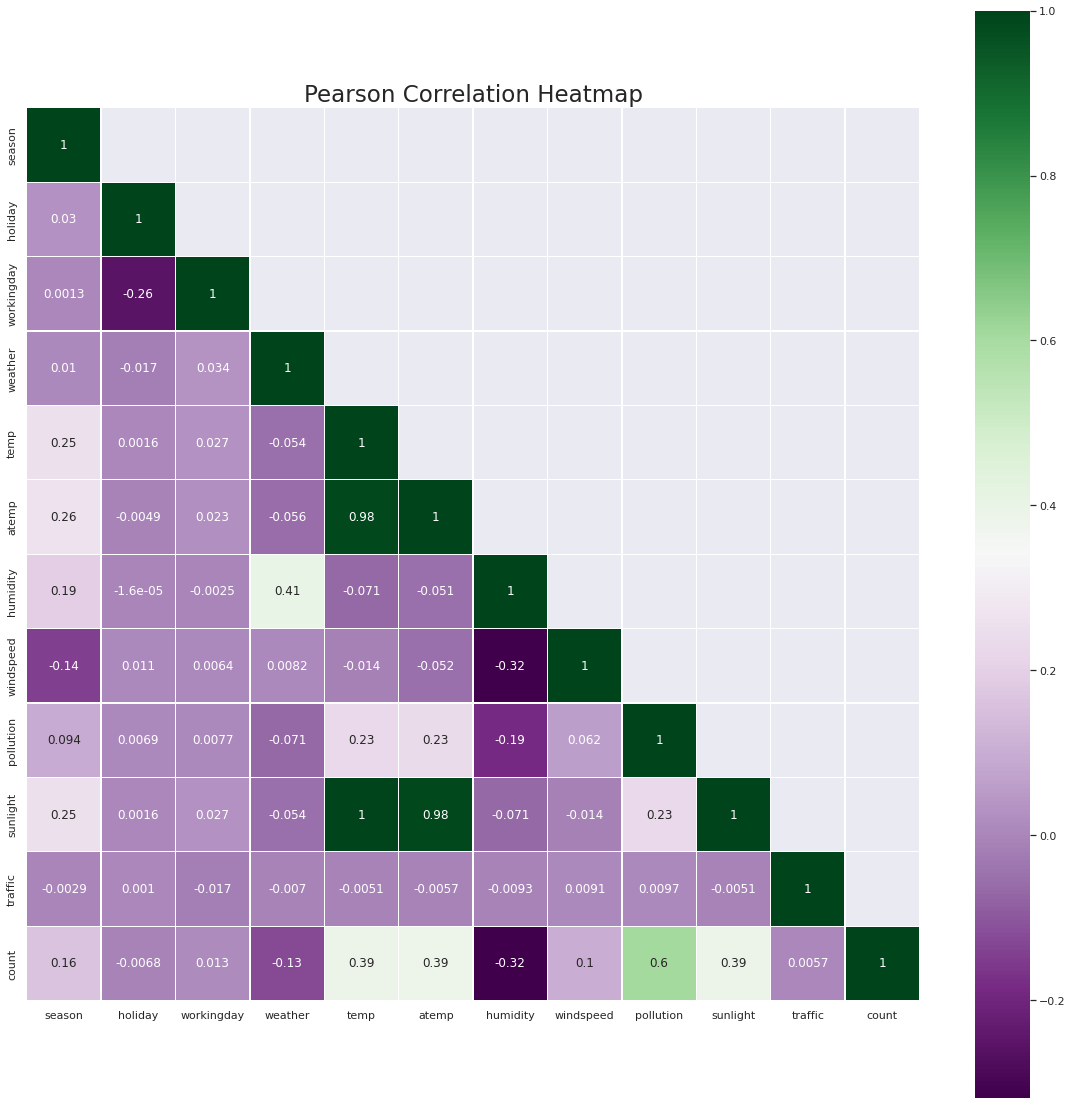

In [ ]:
mask = np.zeros_like(correlations, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

fig, ax = plt.subplots(figsize=(20, 20))
plt.title('Pearson Correlation Heatmap', fontsize=23)

sns.heatmap(correlations, linewidths=0.25, vmax=1.0, square=True, cmap="PRGn",
            linecolor='w', annot=True, mask=mask)

We can see in the heatmap that we have 3 features with high correlation: "temp", "atemp" and "sunlight". We would like to take out the "temp" feature because we can see that "temp" and "sunlight" are in perfect correlation (1, as can be seen in the heatmap). Also, we assume that people rent bikes according to the temperature they feel (represented by "atemp") and not the temperatured measured ("temp"). Because we can see that "temp" and "atemp" are also in high correlation (0.98), we would prefer to remove the "temp" feature.

Check for null values:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164 entries, 0 to 8163
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    8164 non-null   object 
 1   season      8164 non-null   int64  
 2   holiday     8164 non-null   int64  
 3   workingday  8164 non-null   int64  
 4   weather     8164 non-null   int64  
 5   temp        8164 non-null   float64
 6   atemp       8164 non-null   float64
 7   humidity    8164 non-null   int64  
 8   windspeed   8164 non-null   float64
 9   pollution   8164 non-null   float64
 10  sunlight    8164 non-null   float64
 11  traffic     8164 non-null   float64
 12  count       8164 non-null   int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 829.3+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2722 entries, 0 to 2721
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    2722 non-null   object 
 1   season      2722 non-null   int64  
 2   holiday     2722 non-null   int64  
 3   workingday  2722 non-null   int64  
 4   weather     2722 non-null   int64  
 5   temp        2722 non-null   float64
 6   atemp       2722 non-null   float64
 7   humidity    2722 non-null   int64  
 8   windspeed   2722 non-null   float64
 9   pollution   2722 non-null   float64
 10  sunlight    2722 non-null   float64
 11  traffic     2722 non-null   float64
 12  count       2722 non-null   int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 276.6+ KB


It can be seen that there are no missing values and that almost all the values are numeric except for the datetime variable. so later we'll convert the datetime column to pandas timestamp. 

Now we'll plot the distribution of each feature values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fecae6de970>,
      dtype=object)

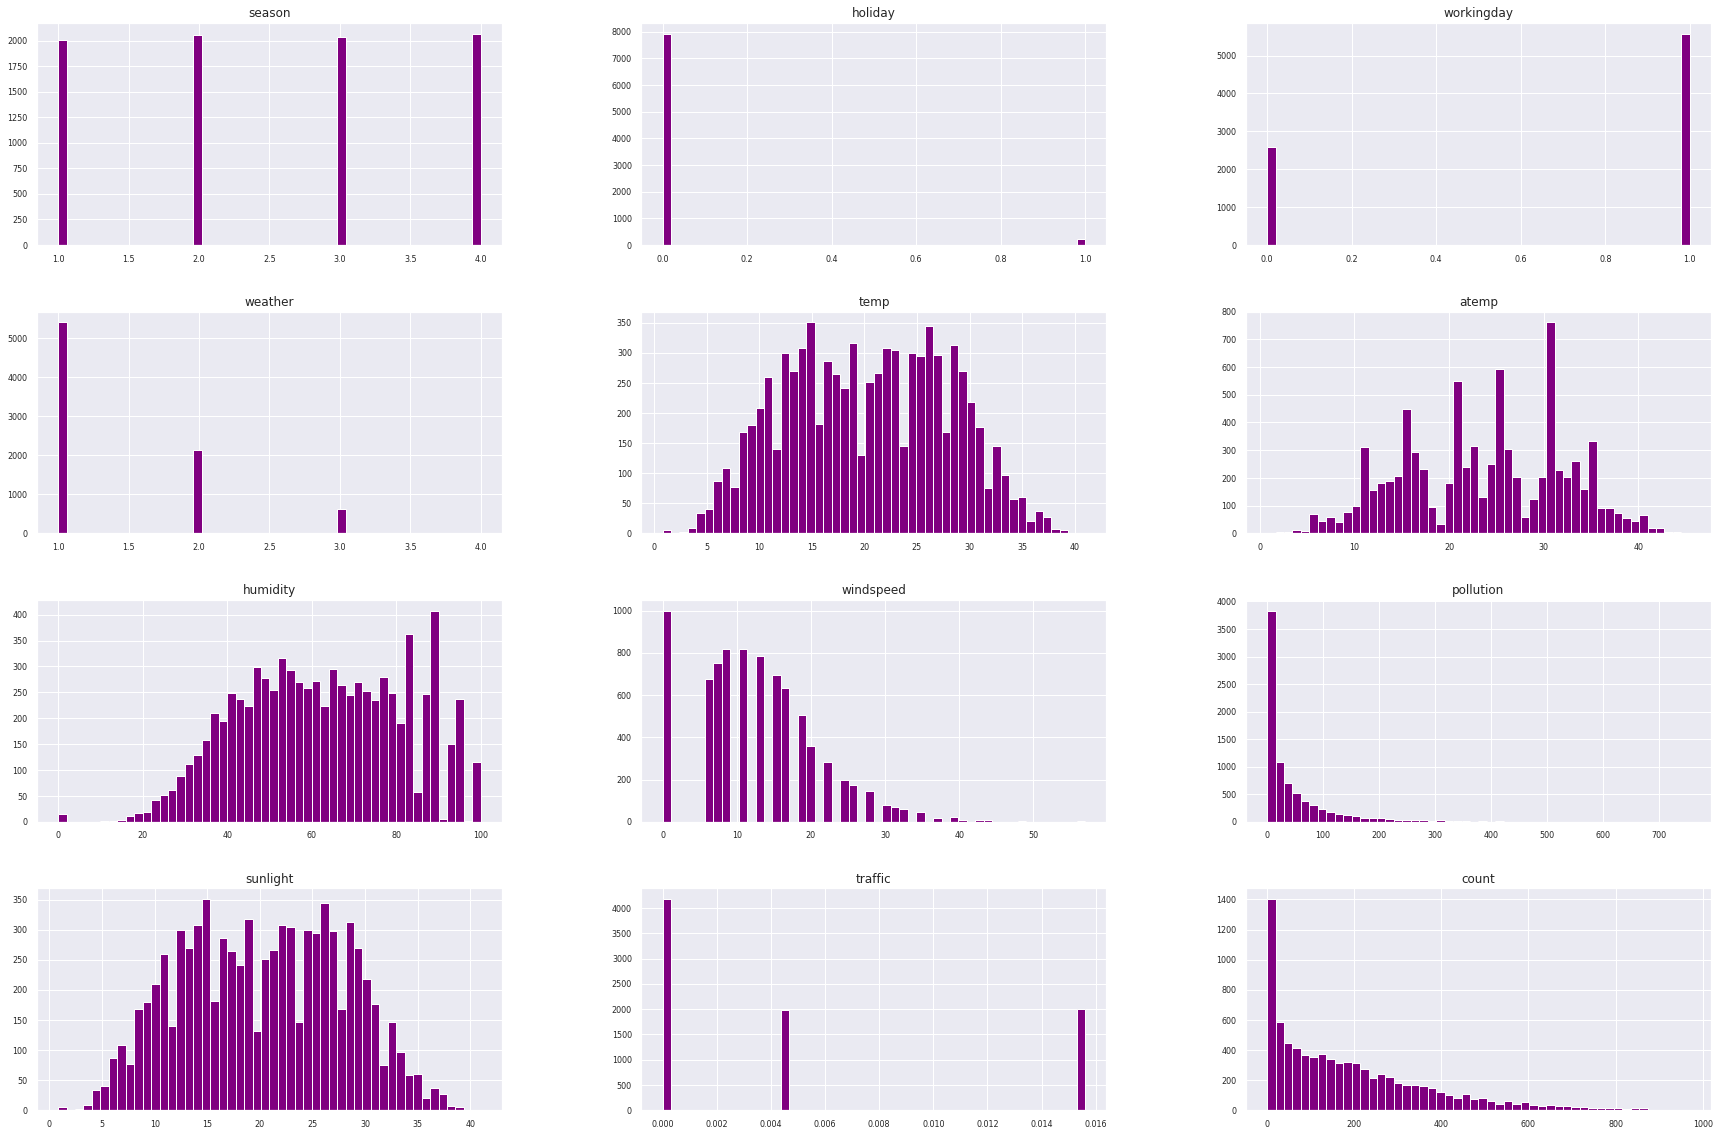

In [ ]:
df.hist(figsize=(30, 20), bins=50, xlabelsize=8, ylabelsize=8, color="purple")

As it seem from the plot above, the feature "temp" looks like a near perfect gausion distribution. Features "pollution" and " count" are asymmetrical Left distribution.
Moreover we can see that features "season", "holiday", "workingday" and "weather" are categorial features.




## A look on the Categorial & Binary Columns

Let's see the visualization of the categories in each categorical feature

In [ ]:
data_category = df[['season','holiday','workingday','weather']]


Feature name: season


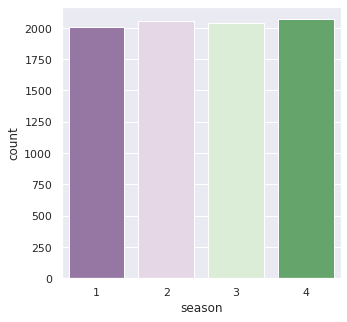

Feature name: holiday


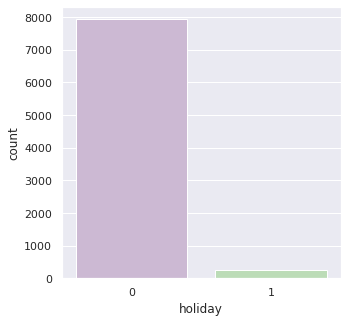

Feature name: workingday


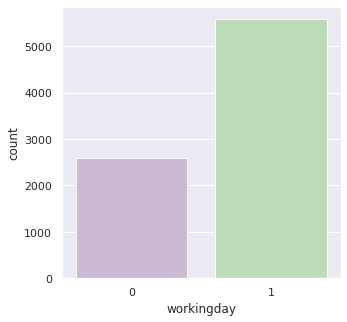

Feature name: weather


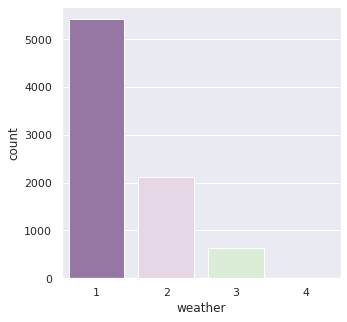

In [ ]:
def categorial_dist(df):
    for column in df:                                                 
            print ('Feature name:', column)
            fig, ax =plt.subplots(figsize=(5, 5))                                  
            sns.countplot(df[column], palette="PRGn")
            plt.show()
categorial_dist(data_category)

It can be seen that the amount of bicycle rental is relatively balanced between the four seasons. In addition, as expected, most observations are on working days and less on holidays and weekends. Also, it can be seen that most of our observations are from the winter season significantly more than the other seasons.

**converting the timestamp column of Object Data type to pandas-DateTime Data Type. It’s important so we can aggregate our data and resample it as per our need**

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164 entries, 0 to 8163
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    8164 non-null   datetime64[ns]
 1   season      8164 non-null   int64         
 2   holiday     8164 non-null   int64         
 3   workingday  8164 non-null   int64         
 4   weather     8164 non-null   int64         
 5   temp        8164 non-null   float64       
 6   atemp       8164 non-null   float64       
 7   humidity    8164 non-null   int64         
 8   windspeed   8164 non-null   float64       
 9   pollution   8164 non-null   float64       
 10  sunlight    8164 non-null   float64       
 11  traffic     8164 non-null   float64       
 12  count       8164 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(6)
memory usage: 829.3 KB


plotting the count column against datetime

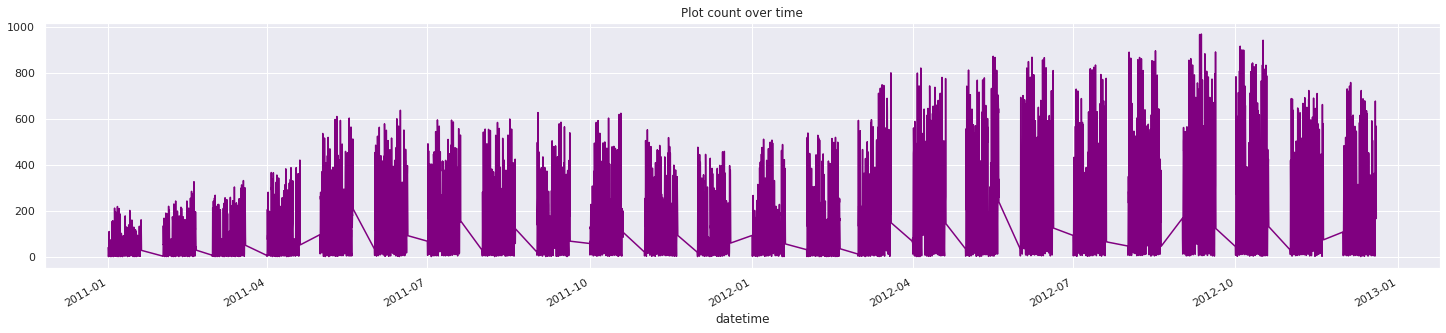

In [ ]:
df.set_index(['datetime'])['count'].plot(title='Plot count over time', figsize=(25, 5), color="purple");

We only have partial data for 2013, so we will only look at plots for 2011 and 2012, where we have full 12 months.
It can be seen that the amount of bicycle rental is somewhat similar from year to year but increases from year to year.

Let's check if the count column is an aggregate value or specific to a certain time:


In [ ]:
df.sort_values(by='datetime', inplace= True)
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count
6560,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,10.820673,9.021,0.000000,40
3754,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,19.189498,9.021,0.004489,32
7767,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.133472,9.841,0.015615,1
7272,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0.014335,9.841,0.000000,1
5381,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,0.096936,9.021,0.004489,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4763,2012-12-19 16:00:00,4,0,1,1,17.22,21.210,50,23.9994,19.956957,17.221,0.015615,334
467,2012-12-19 18:00:00,4,0,1,1,15.58,19.695,50,23.9994,212.578827,15.581,0.004489,569
4423,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,21.027171,15.581,0.015615,336
3307,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,37.737255,14.761,0.004489,241


as we can see the count value is specific to a certain time

Now we'll compare the monthly bicycles rental between the years 2011 and 2012 given in the samples

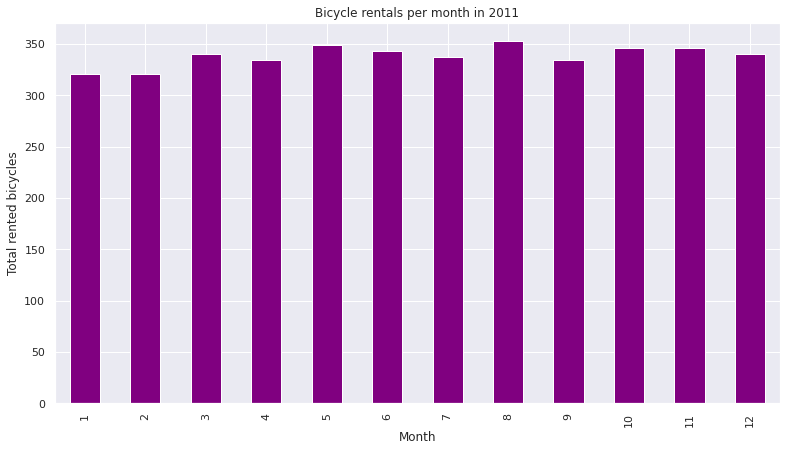

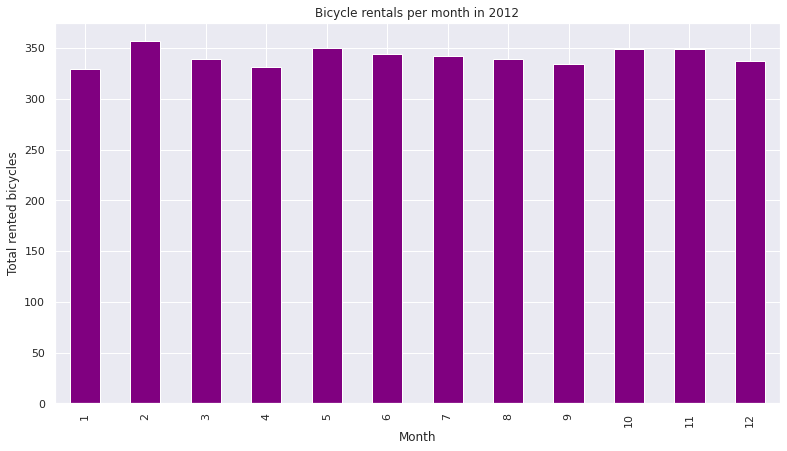

In [ ]:
def plot_By_year(df,yearofpurchase):

  df_filter = df[df.apply(lambda row: row['datetime'].year == yearofpurchase, axis=1)]
  df_filter['month'] = pd.DatetimeIndex(df_filter['datetime']).month
  pur_month=df_filter.loc[(df_filter['count'] > 0) , 'month']
  pur_month.value_counts(sort=False).plot.bar(color="purple", figsize=(13,7))
  plt.xlabel('Month')
  plt.ylabel('Total rented bicycles')
  plt.title(f'Bicycle rentals per month in '+ str(yearofpurchase))
  plt.show()
    
plot_By_year(df, 2011)
plot_By_year(df, 2012)

As we mentioned before, it is now more clear that there is a similarity in the distribution of demand for bicycles over the years, but that in some months the demand is greater than the year before.

**Now we'll take a look at the demand by months, days and hours**

In [ ]:
# Plot by day, hour and month
def plot_sum_by_datettime(df,col):
  if col=='month':
    df1 = df.groupby(df.datetime.dt.month)['count'].sum()
  elif col=='day':
    df1 = df.groupby(df.datetime.dt.day)['count'].sum()
  elif col=='time':
    df1 = df.groupby(df.datetime.dt.time)['count'].sum()
  elif col=='weekday':
    df1 = df.groupby(df.datetime.dt.weekday)['count'].sum()
  df1.plot.bar(color="purple", figsize=(15,10))
  plt.xlabel(col)
  plt.ylabel('Sum of rented bicycles')
  plt.title(f'Bicycle rentals per '+ str(col))
  plt.show()


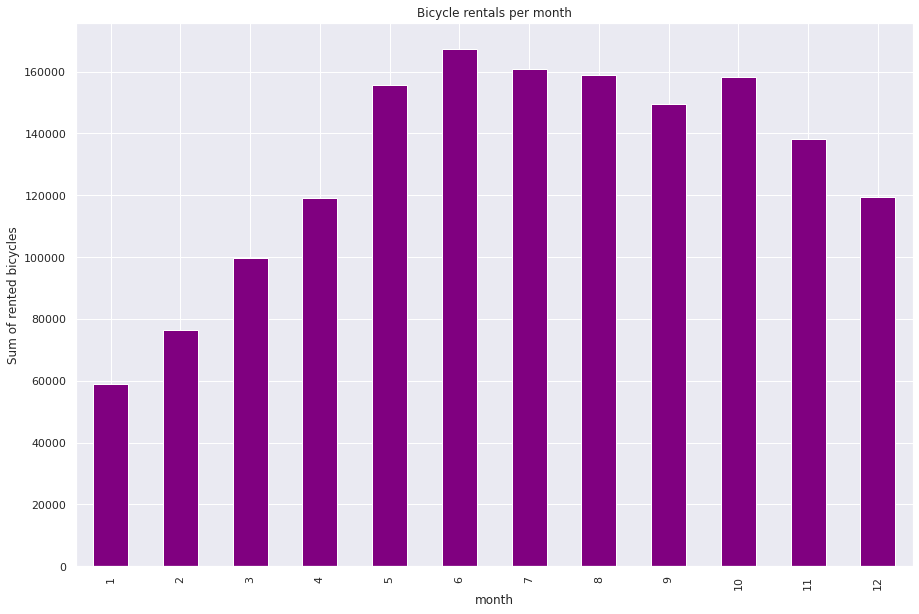

In [ ]:
plot_sum_by_datettime(df,'month')

from the bicycle rental per month plot we can see that there are a few levels of demand:
*   the highest demand level1 : 6,7,8
*   level2 : 5,9,10
*   level3 : 4,11,12
*   the lowest , level4: 1,2,3

In one of the model trainings that we tried , we created new features of these levels by months but we didn't saw an improvement in the performance of the models, and so we chose not to do this in the final model.












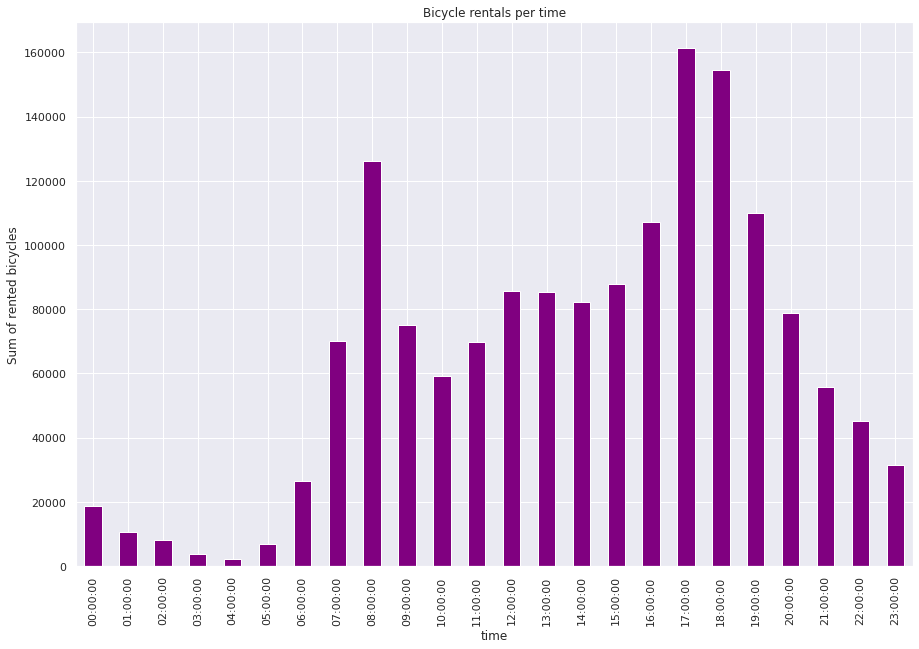

In [ ]:
plot_sum_by_datettime(df,'time')

from the bicycle rental per time plotwe have two periods of rush hours: 08:00-09:00 and 17:00-19:00. We also have clear off-peak hours, 00:00-06:00.
Due to this,we would like to express this information in the form of dummy variables and we'll do it in the preprocessing stage. 



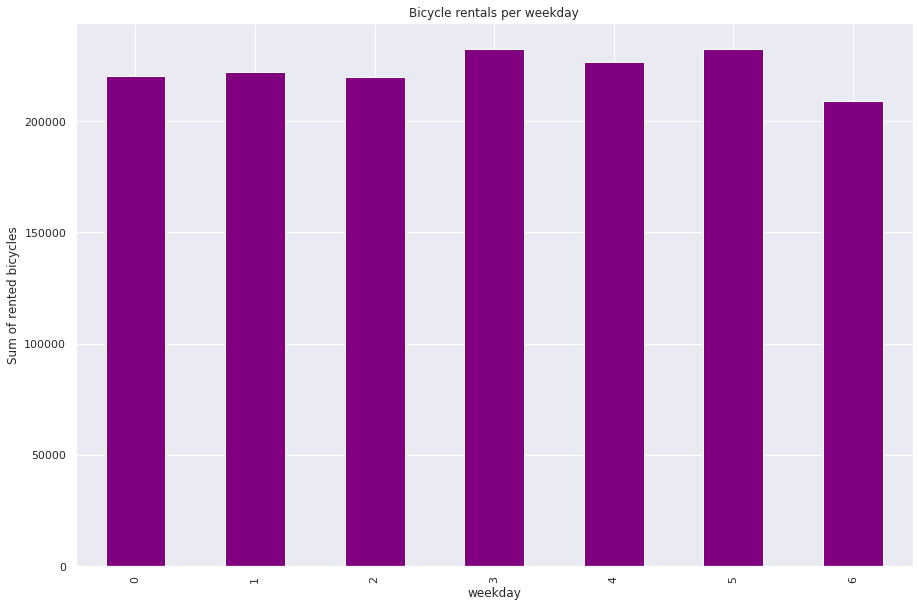

In [ ]:
plot_sum_by_datettime(df,'weekday')

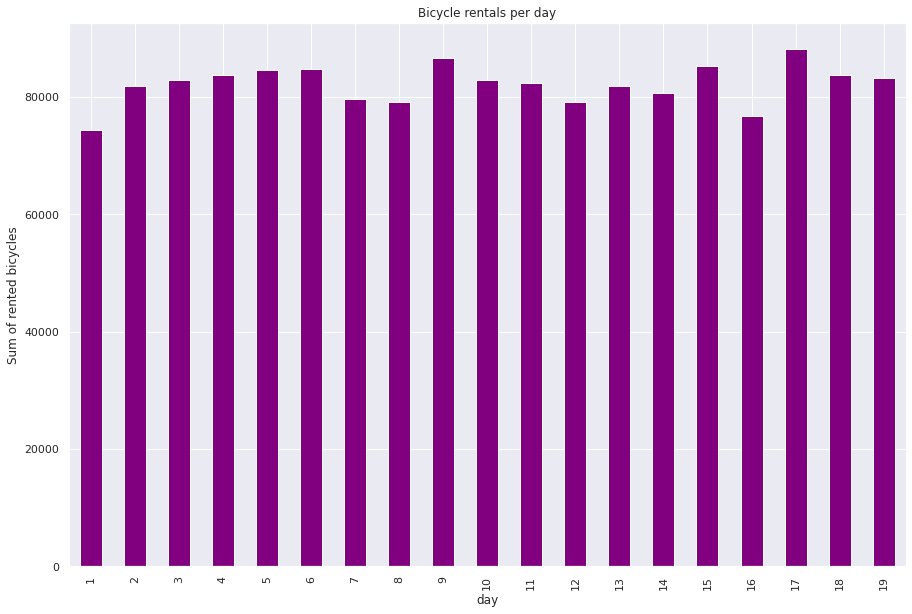

In [ ]:
plot_sum_by_datettime(df,'day')

# Preprocessing

**Here are the actions we will perform in the pre-processing based on the exploration from the previous step:**


1. create dummy variables for "season" and "weather".
2. remove high corelative columns.
3. normelize the humidity column - manualy. 
4. convert the "datetime" column to a format we can use : year, month, time.
5. create additional columns that reflect the relevant rush hour according to the time ranges we've found in the exploration stage: rush hours and off-peak hours.


**Below are all the pre-processing actions we performed that didn't contribute to the performance of the models and decided not to perform them on the final model :**
1. We created new features of demand levels by month and concentrated in each feature the 3 months with a similar level of demand.
2. We created a dummies variable for day, month and year features.
3. creating a ordinal based year feature - that the base year in 2011 and deleting the original year feature.
4. We created new variables for features that had a significant contribution to the models after we ran them - feature the variables in the square and feature the relevant variables in the log.
5. We did normalization using both standard and minmax methods.
6. Creating new features using the PCA method.

All these actions together,separately and in different combinations, only increased the model error and therefore we chose to give them up in the final model.

In [ ]:
def data_preproessing(dataframe):
  # creating a copy of the data
  df_copy = dataframe.copy()

  # removing the high corelative feature: temp, sunlight
  removing_temp = df_copy.pop('temp')
  removing_sunlight = df_copy.pop('sunlight')

  # split datetime to year, month and hour
  df_copy['time'] = pd.to_datetime(df_copy['datetime']).dt.time
  df_copy['month'] = pd.to_datetime(df_copy['datetime']).dt.month
  df_copy['year'] = pd.to_datetime(df_copy['datetime']).dt.year
  # split datetime to weekday
  df_copy['day'] = pd.to_datetime(df_copy['datetime']).dt.weekday # Monday is 0 and Sunday is 6
  df_copy['hour'] = pd.to_datetime(df_copy['datetime']).dt.hour
  df_copy.drop(['datetime'], axis=1, inplace=True) #drop datetime column
  # Add new features: 'rush_h' and 'off-peak_h'
  df_copy['rush_h'] = df_copy.loc[:, 'time']
  df_copy['offpeak_h'] = df_copy.loc[:, 'time']
  m_rush1, m_rush2 = time(8), time(9) # 08:00, 09:00, morning rush hours
  e_rush1, e_rush2 = time(17), time(19) # 17:00, 19:00, evning rush hours
  o_p1 , o_p2 = time(0), time(7) #off-peak hours
  # Filling up the dummy variables of off-peak and rush hour
  df_copy["rush_h"] = np.where(((df_copy["time"] >= m_rush1) & (df_copy["time"] < m_rush2)) | ((df_copy["time"] >= e_rush1) & (df_copy["time"] < e_rush2)) , 1, 0)
  df_copy["offpeak_h"] = np.where((df_copy["time"] >= o_p1) & (df_copy["time"] < o_p2) , 1, 0)
  df_copy.drop(['time'], axis=1, inplace=True) #deleting time col
  

  # converting the categorial features: season and weather into dummies
  df_copy = pd.get_dummies(df_copy, columns=['season', 'weather'],drop_first=True) 
  
  # normelizing the humidity feature
  df_copy['humidity'] = df_copy['humidity']/100

  return df_copy

In [ ]:
#utilty function to removing features:

def remove_excess_features(dataframe, features):
  for feature in features:
    feature = dataframe.pop(feature)

**Applying the preprocessing to the training and test models**

In [ ]:
df_copy = data_preproessing(df)
df_test = data_preproessing(df_test)

let's check the train and test dataframes after the preprocessing

In [ ]:
df_copy

,holiday,workingday,atemp,humidity,windspeed,pollution,traffic,count,month,year,day,hour,rush_h,offpeak_h,season_2,season_3,season_4,weather_2,weather_3,weather_4
6560,0,0,13.635,0.80,0.0000,10.820673,0.000000,40,1,2011,5,1,0,1,0,0,0,0,0,0
3754,0,0,13.635,0.80,0.0000,19.189498,0.004489,32,1,2011,5,2,0,1,0,0,0,0,0,0
7767,0,0,14.395,0.75,0.0000,0.133472,0.015615,1,1,2011,5,4,0,1,0,0,0,0,0,0
7272,0,0,12.880,0.75,6.0032,0.014335,0.000000,1,1,2011,5,5,0,1,0,0,0,1,0,0
5381,0,0,13.635,0.80,0.0000,0.096936,0.004489,2,1,2011,5,6,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4763,0,1,21.210,0.50,23.9994,19.956957,0.015615,334,12,2012,2,16,0,0,0,0,1,0,0,0
467,0,1,19.695,0.50,23.9994,212.578827,0.004489,569,12,2012,2,18,1,0,0,0,1,0,0,0
4423,0,1,19.695,0.50,26.0027,21.027171,0.015615,336,12,2012,2,19,0,0,0,0,1,0,0,0
3307,0,1,17.425,0.57,15.0013,37.737255,0.004489,241,12,2012,2,20,0,0,0,0,1,0,0,0


In [ ]:
df_test

,holiday,workingday,atemp,humidity,windspeed,pollution,traffic,count,month,year,day,hour,rush_h,offpeak_h,season_2,season_3,season_4,weather_2,weather_3
0,0,1,40.150,0.59,0.0000,10.317020,0.015615,127,7,2011,1,11,0,0,0,1,0,0,0
1,1,0,6.820,0.54,6.0032,3.502209,0.004489,13,1,2012,0,6,0,1,0,0,0,0,0
2,0,0,11.365,0.48,12.9980,25.945915,0.000000,163,12,2011,6,18,1,0,0,0,1,0,0
3,0,1,34.090,0.62,12.9980,116.935908,0.004489,233,8,2012,2,10,0,0,0,1,0,1,0
4,0,1,31.060,0.53,16.9979,120.824789,0.015615,222,6,2012,4,23,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,0,0,24.240,0.29,27.9993,44.665581,0.000242,313,3,2011,5,15,0,0,0,0,0,0,0
2718,0,0,20.455,0.37,19.9995,31.090380,0.000000,314,1,2012,6,16,0,0,0,0,0,0,0
2719,0,1,31.060,0.74,8.9981,1.075298,0.015615,26,7,2011,0,5,0,1,0,1,0,0,0
2720,0,0,31.060,0.65,11.0014,2.291586,0.004489,127,7,2011,5,8,1,0,0,1,0,0,0


Just before moving on, let's look at the correlation table between the features after the preprocessing

In [ ]:
corr = df_copy.corr()

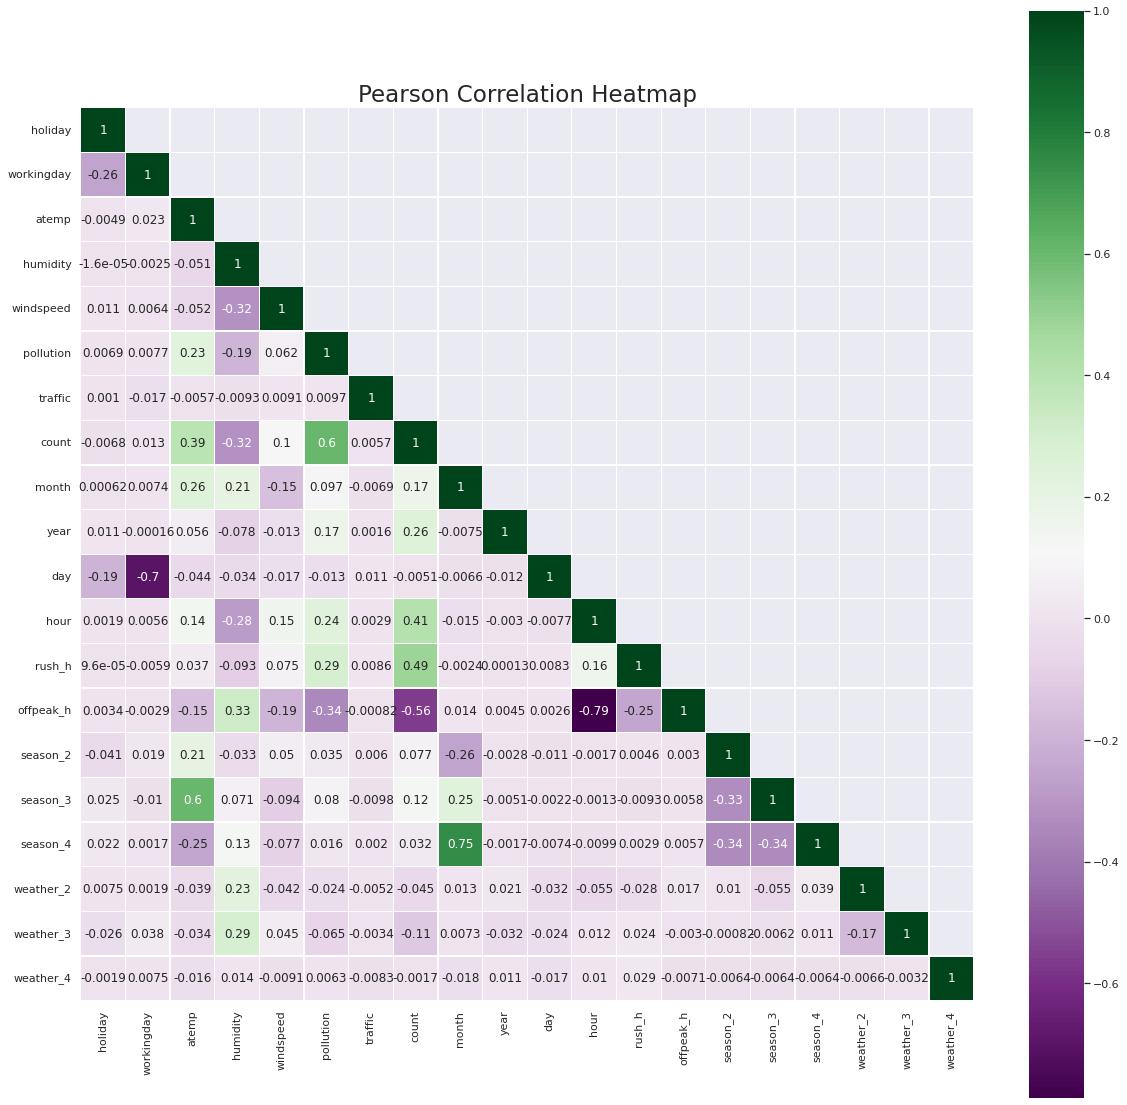

In [ ]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

fig, ax = plt.subplots(figsize=(20, 20))
plt.title('Pearson Correlation Heatmap', fontsize=23)

sns.heatmap(corr, linewidths=0.25, vmax=1.0, square=True, cmap="PRGn", annot=True, mask=mask)

From the updated correlation table, it can be seen that there is a correlation between season 4 and the month and also between season 3 and temperature. Therefore we will decide to remove the variables season 3 and season 4.


In [ ]:
#removing unwanted features:
remove_features =  ['season_2', 'season_3', 'season_4']

#for the train
remove_excess_features(df_copy, remove_features)
#for the test
remove_excess_features(df_test, remove_features)

# split the dataframe
count is our target (the number of bike rented) so we'll split the dataframe to two numpy parts:

In [ ]:
Y = np.array(df_copy.pop('count'))
X = np.array(df_copy)


spliting the train data to train and validation :

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

#print(x_train.shape)
#print(x_test.shape)

# Training the models



Those are the model we'll train:

*   Linear regression
*   Decision tree
*   Random forest





In [ ]:
#creating a dictionary to collect the result of each model
models = {'Linear regression': None,
          'Decision tree': None,
          'Random forest': None}

# Linear regression

In [ ]:
def run_linear_regression(x_train, y_train):
  t0 = t.time()
  reg = LinearRegression()
  reg.fit(x_train, np.ravel(y_train))
  cv_score = cross_val_score(reg, x_train, y_train, scoring='neg_root_mean_squared_error', cv=3)
  print(f'Runtime: {round(t.time()-t0,2)} seconds')
  return reg, cv_score

#Decision Tree

In [ ]:
def run_decision_tree(x_train, y_train):
  #for displaying the runtime
  t0 = t.time()
  dt = DecisionTreeRegressor(random_state=42)
  tuned_dt = GridSearchCV(estimator=dt, 
                          param_grid={'max_depth':[1, 2, 5, 10], 
                                      'max_features': ['auto', 'sqrt', 'log2', 1/3]},
                          scoring='neg_root_mean_squared_error',
                          cv=3, 
                          verbose=3)
  tuned_dt.fit(x_train, y_train)
  print(f'Runtime: {round(t.time()-t0,2)} seconds')
  return tuned_dt

# Random Forest

In [ ]:
def run_random_forest(x_train, y_train):
  t0 = t.time()
  rf = RandomForestRegressor(n_estimators=120, random_state=42)
  tuned_rf = GridSearchCV(estimator=rf, 
                          param_grid={'max_features': ['auto', 'sqrt', 'log2', 1/3]},
                          scoring='neg_root_mean_squared_error',
                          cv=3, 
                          verbose=3,
                          refit=True)
  tuned_rf.fit(x_train, y_train)
  print(f'Runtime: {round(t.time()-t0,2)} seconds')
  return tuned_rf

# Train and fit the models

In [ ]:
def run_all_models(x, y):
  models_dict = {}
  models_dict['Linear regression'] = run_linear_regression(x, y)
  models_dict['Decision tree'] = run_decision_tree(x, y)
  models_dict['Random forest'] = run_random_forest(x, y)
  return models_dict

In [ ]:
y_train = pd.DataFrame(y_train)
models = run_all_models(x_train, y_train.values.ravel())


Runtime: 0.07 seconds
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END .max_depth=1, max_features=auto;, score=-150.841 total time=   0.0s
[CV 2/3] END .max_depth=1, max_features=auto;, score=-149.253 total time=   0.0s
[CV 3/3] END .max_depth=1, max_features=auto;, score=-149.260 total time=   0.0s
[CV 1/3] END .max_depth=1, max_features=sqrt;, score=-175.071 total time=   0.0s
[CV 2/3] END .max_depth=1, max_features=sqrt;, score=-173.963 total time=   0.0s
[CV 3/3] END .max_depth=1, max_features=sqrt;, score=-176.641 total time=   0.0s
[CV 1/3] END .max_depth=1, max_features=log2;, score=-175.071 total time=   0.0s
[CV 2/3] END .max_depth=1, max_features=log2;, score=-173.963 total time=   0.0s
[CV 3/3] END .max_depth=1, max_features=log2;, score=-176.641 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=0.3333333333333333;, score=-158.236 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=0.3333333333333333;, score=-156.803 total time=   0.0s


# Let's take a view on the current results of each model:

In [ ]:
models

{'Linear regression': (LinearRegression(),
  array([ -98.64316665,  -99.02472547, -101.75548538])),
 'Decision tree': GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
              param_grid={'max_depth': [1, 2, 5, 10],
                          'max_features': ['auto', 'sqrt', 'log2',
                                           0.3333333333333333]},
              scoring='neg_root_mean_squared_error', verbose=3),
 'Random forest': GridSearchCV(cv=3,
              estimator=RandomForestRegressor(n_estimators=120, random_state=42),
              param_grid={'max_features': ['auto', 'sqrt', 'log2',
                                           0.3333333333333333]},
              scoring='neg_root_mean_squared_error', verbose=3)}

# Models comparison

In [ ]:
cv_scores = {}
cv_scores['Linear regression'] =  models['Linear regression'][1].mean()
cv_scores['Decision tree'] = models['Decision tree'].best_score_
cv_scores['Random forest'] = models['Random forest'].best_score_

cv_scores

{'Linear regression': -99.80779249949558,
 'Decision tree': -80.55848789115896,
 'Random forest': -53.59084644643486}

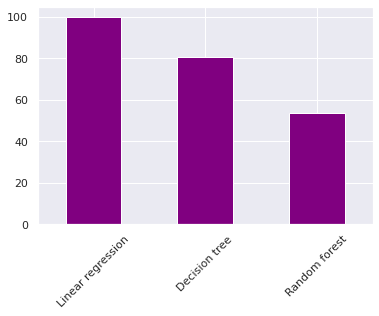

In [ ]:
sns.set()
cv_scores_df = -pd.DataFrame.from_dict(cv_scores, orient='index')
cv_scores_df.plot.bar(rot=45, legend=False, color="purple")

From the results above, it can be seen that the random forest model has the lowest error. In order to try to improve the results of the models, we'll try to analyze the features that contribute the most to the current models in order to find the optimal features to each model.

# We'll check which feature have the most significant influence for each model in order to improve the results

**Decision tree feature importance:**

In [ ]:
models['Decision tree'].best_params_

{'max_depth': 10, 'max_features': 'auto'}

In [ ]:
feature_importance_dict = {}

best_tree = DecisionTreeRegressor(max_depth=10, max_features="auto")
best_tree.fit(x_train, y_train)
tree_features = best_tree.feature_importances_

feature_importance_dict["Decision tree"] = tree_features

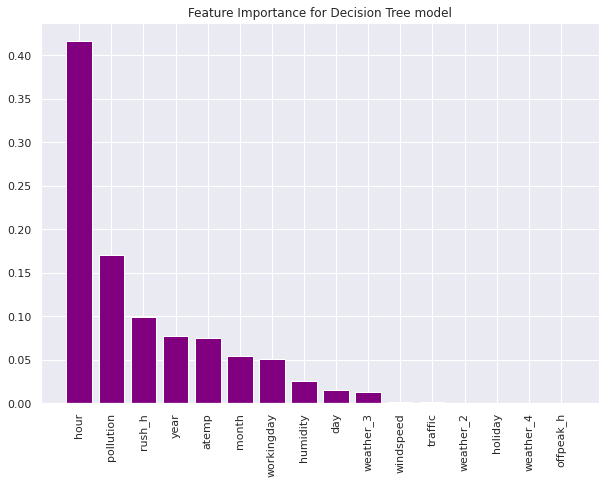

In [ ]:
sorted_tree_features_importance = np.argsort(tree_features)[::-1]

plt.figure(figsize=(10,7))
plt.title("Feature Importance for Decision Tree model")
plt.bar(range(x_train.shape[1]), tree_features[sorted_tree_features_importance], color="purple")
plt.xticks(range(x_train.shape[1]), df_copy.columns[sorted_tree_features_importance], rotation='vertical')
plt.show()

**Random forest feature importance:**

In [ ]:
models['Random forest'].best_params_

{'max_features': 'auto'}

In [ ]:
best_rand = RandomForestRegressor(n_estimators=120, max_depth=10, max_features="auto")
best_rand.fit(x_train, y_train)
forest_features = best_rand.feature_importances_


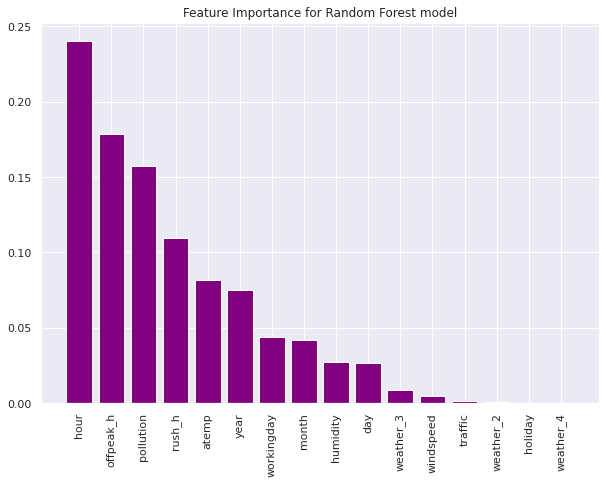

In [ ]:
sorted_forest_features_importance = np.argsort(forest_features)[::-1]


plt.figure(figsize=(10,7))
plt.title("Feature Importance for Random Forest model")
plt.bar(range(x_train.shape[1]), forest_features[sorted_forest_features_importance], color="purple")
plt.xticks(range(x_train.shape[1]), df_copy.columns[sorted_forest_features_importance], rotation='vertical')
plt.show()

from the random forest and decision tree it can be seen that the new features we created for the rush hours are among the most significant variables for those models. In addition, it can be seen that the features with the lowest contribution to the model are the weather 2 and 4 and also the holiday feature.

In [ ]:
def evaluate_single_model(x, y, model):
  y_pred = model.predict(x)
  return mean_squared_error(y, y_pred)

def evaluate_all_models(x, y, models_dict):
  test_set_scores = {}
  for k, v in models_dict.items():
    test_set_scores[k] = evaluate_single_model(x, y, v)
  return test_set_scores


trained_models_dict = {}
trained_models_dict['Random forest'] = models['Random forest'].best_estimator_
trained_models_dict['Decision tree'] = models['Decision tree'].best_estimator_
trained_models_dict['Linear regression'] = models['Linear regression'][0]
trained_models_dict

{'Random forest': RandomForestRegressor(n_estimators=120, random_state=42),
 'Decision tree': DecisionTreeRegressor(max_depth=10, max_features='auto', random_state=42),
 'Linear regression': LinearRegression()}

In [ ]:
evaluate_all_models(x_val, y_val, trained_models_dict)

{'Random forest': 2635.7238848489487,
 'Decision tree': 5752.328822762125,
 'Linear regression': 10445.970453916547}

**Estimation for feature importance for linear regression:**

[-9.03187389e+00  4.22729872e+00  4.56132938e+00 -1.05590330e+02
 -8.29914146e-02  7.19903362e-01  9.00372100e+01  6.12175091e+00
  6.90085355e+01  4.82387615e-01 -1.81550954e+00  1.62674019e+02
 -1.51619771e+02 -3.99044088e+00 -3.98166340e+01 -1.53744056e+02]


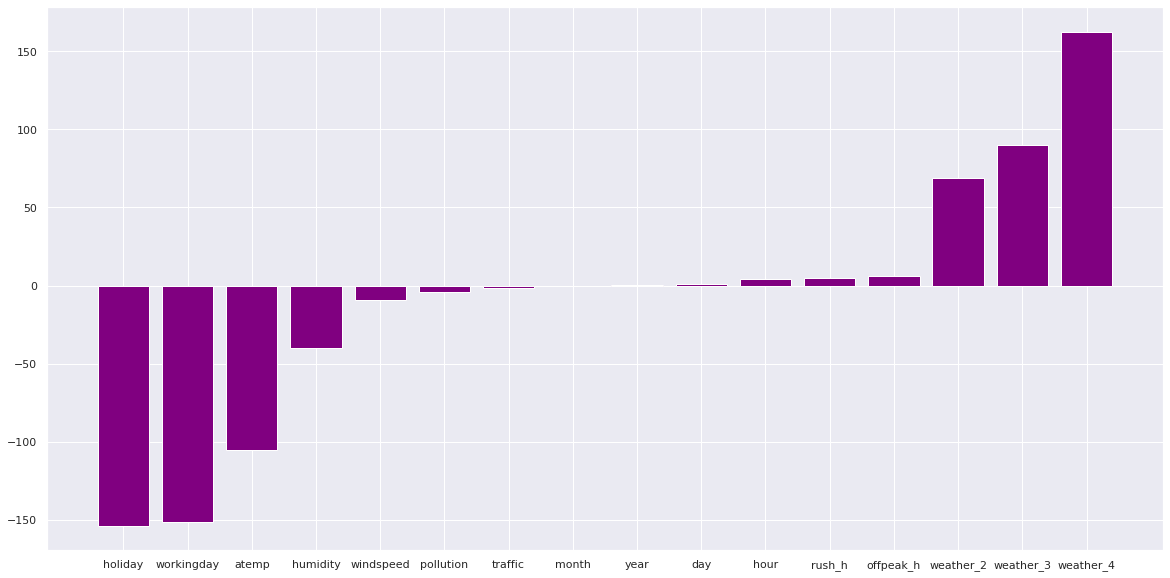

In [ ]:
# get importance
lr_importance = trained_models_dict['Linear regression'].coef_

print(lr_importance)


# plot feature importance
fig = plt.subplots(figsize=(20,10))
plt.bar(df_copy.columns, np.sort(lr_importance), color="purple")
plt.show()

From the graph of the coefficients of the linear regression, it can be estimated that the features traffic load, air pollution, and the weather have the lowest impact on the result.

**Now we'll try to run the models only with the most significant features for each model**

In [ ]:
best_features_dict = {}

best_features_dict['Decision tree'] = sorted_tree_features_importance[:12] #taking best features, after trying different slicingd
best_features_dict['Random forest'] = sorted_forest_features_importance[:12] #taking best features, after trying different slicingd
best_features_dict['Linear regression'] = np.array([0, 1, 2, 3, -3, -2, -1])
# in linear regression we are taking the features with highest and lowest coefficients, because they are the ones effecting the model the most

best_features_dict

{'Decision tree': array([10,  5, 11,  8,  2,  7,  1,  3,  9, 14,  4,  6]),
 'Random forest': array([10, 12,  5, 11,  2,  8,  1,  7,  3,  9, 14,  4]),
 'Linear regression': array([ 0,  1,  2,  3, -3, -2, -1])}

# Now we'll Train the models with the most significant features we've found above 

In [ ]:
new_lr = run_linear_regression(x_train[:, best_features_dict['Linear regression']],y_train)
new_tree = run_decision_tree(x_train[:, best_features_dict['Decision tree']], y_train)
new_forest = run_random_forest(x_train[:, best_features_dict['Random forest']], y_train)



Runtime: 0.05 seconds
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END .max_depth=1, max_features=auto;, score=-150.841 total time=   0.0s
[CV 2/3] END .max_depth=1, max_features=auto;, score=-149.253 total time=   0.0s
[CV 3/3] END .max_depth=1, max_features=auto;, score=-149.260 total time=   0.0s
[CV 1/3] END .max_depth=1, max_features=sqrt;, score=-168.717 total time=   0.0s
[CV 2/3] END .max_depth=1, max_features=sqrt;, score=-168.597 total time=   0.0s
[CV 3/3] END .max_depth=1, max_features=sqrt;, score=-170.197 total time=   0.0s
[CV 1/3] END .max_depth=1, max_features=log2;, score=-168.717 total time=   0.0s
[CV 2/3] END .max_depth=1, max_features=log2;, score=-168.597 total time=   0.0s
[CV 3/3] END .max_depth=1, max_features=log2;, score=-170.197 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=0.3333333333333333;, score=-168.717 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=0.3333333333333333;, score=-168.597 total time=   0.0s


In [ ]:
pred_tree = new_tree.predict(x_val[:, best_features_dict['Decision tree']])
pred_forest = new_forest.predict(x_val[:, best_features_dict['Random forest']])
pred_lr = new_lr[0].predict(x_val[:, best_features_dict['Linear regression']])

**Checking new scores**

In [ ]:
new_scores = {}

new_scores[new_tree] = np.sqrt(mean_squared_error(y_val, pred_tree))
new_scores[new_forest] = np.sqrt(mean_squared_error(y_val, pred_forest))
new_scores[new_lr[0]] = np.sqrt(mean_squared_error(y_val, pred_lr))

new_scores

{GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
              param_grid={'max_depth': [1, 2, 5, 10],
                          'max_features': ['auto', 'sqrt', 'log2',
                                           0.3333333333333333]},
              scoring='neg_root_mean_squared_error', verbose=3): 75.12462740481872,
 GridSearchCV(cv=3,
              estimator=RandomForestRegressor(n_estimators=120, random_state=42),
              param_grid={'max_features': ['auto', 'sqrt', 'log2',
                                           0.3333333333333333]},
              scoring='neg_root_mean_squared_error', verbose=3): 50.582603825229114,
 LinearRegression(): 159.8279811623265}

In [ ]:
new_trained_models_dict = {}
new_trained_models_dict['Random forest'] = models['Random forest'].best_estimator_
new_trained_models_dict['Decision tree'] = models['Decision tree'].best_estimator_
new_trained_models_dict['Linear regression'] = models['Linear regression'][0]
new_trained_models_dict

{'Random forest': RandomForestRegressor(n_estimators=120, random_state=42),
 'Decision tree': DecisionTreeRegressor(max_depth=10, max_features='auto', random_state=42),
 'Linear regression': LinearRegression()}

In [ ]:
evaluate_all_models(x_val, y_val, new_trained_models_dict)

{'Random forest': 2635.7238848489487,
 'Decision tree': 5752.328822762125,
 'Linear regression': 10445.970453916547}

# Evaluating on test set

Let's evaluate all models:

In [ ]:
df_copy.shape

(8164, 16)

In [ ]:
df_test.shape

(2722, 16)

We are missing one column, we would like to see which one is missing

In [ ]:
df_copy

,holiday,workingday,atemp,humidity,windspeed,pollution,traffic,month,year,day,hour,rush_h,offpeak_h,weather_2,weather_3,weather_4
6560,0,0,13.635,0.80,0.0000,10.820673,0.000000,1,2011,5,1,0,1,0,0,0
3754,0,0,13.635,0.80,0.0000,19.189498,0.004489,1,2011,5,2,0,1,0,0,0
7767,0,0,14.395,0.75,0.0000,0.133472,0.015615,1,2011,5,4,0,1,0,0,0
7272,0,0,12.880,0.75,6.0032,0.014335,0.000000,1,2011,5,5,0,1,1,0,0
5381,0,0,13.635,0.80,0.0000,0.096936,0.004489,1,2011,5,6,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4763,0,1,21.210,0.50,23.9994,19.956957,0.015615,12,2012,2,16,0,0,0,0,0
467,0,1,19.695,0.50,23.9994,212.578827,0.004489,12,2012,2,18,1,0,0,0,0
4423,0,1,19.695,0.50,26.0027,21.027171,0.015615,12,2012,2,19,0,0,0,0,0
3307,0,1,17.425,0.57,15.0013,37.737255,0.004489,12,2012,2,20,0,0,0,0,0


In [ ]:
df_test

,holiday,workingday,atemp,humidity,windspeed,pollution,traffic,count,month,year,day,hour,rush_h,offpeak_h,weather_2,weather_3
0,0,1,40.150,0.59,0.0000,10.317020,0.015615,127,7,2011,1,11,0,0,0,0
1,1,0,6.820,0.54,6.0032,3.502209,0.004489,13,1,2012,0,6,0,1,0,0
2,0,0,11.365,0.48,12.9980,25.945915,0.000000,163,12,2011,6,18,1,0,0,0
3,0,1,34.090,0.62,12.9980,116.935908,0.004489,233,8,2012,2,10,0,0,1,0
4,0,1,31.060,0.53,16.9979,120.824789,0.015615,222,6,2012,4,23,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,0,0,24.240,0.29,27.9993,44.665581,0.000242,313,3,2011,5,15,0,0,0,0
2718,0,0,20.455,0.37,19.9995,31.090380,0.000000,314,1,2012,6,16,0,0,0,0
2719,0,1,31.060,0.74,8.9981,1.075298,0.015615,26,7,2011,0,5,0,1,0,0
2720,0,0,31.060,0.65,11.0014,2.291586,0.004489,127,7,2011,5,8,1,0,0,0


We can see that we are missing 'weather_4' column, so we will add one full of zeros, so we can run our models properly on the test. We already know there are no missing values from the info table we showed in our exploration.

In [ ]:
df_test.insert(15, 'weather_4', '0')

In [ ]:
df_test

,holiday,workingday,atemp,humidity,windspeed,pollution,traffic,count,month,year,day,hour,rush_h,offpeak_h,weather_2,weather_4,weather_3
0,0,1,40.150,0.59,0.0000,10.317020,0.015615,127,7,2011,1,11,0,0,0,0,0
1,1,0,6.820,0.54,6.0032,3.502209,0.004489,13,1,2012,0,6,0,1,0,0,0
2,0,0,11.365,0.48,12.9980,25.945915,0.000000,163,12,2011,6,18,1,0,0,0,0
3,0,1,34.090,0.62,12.9980,116.935908,0.004489,233,8,2012,2,10,0,0,1,0,0
4,0,1,31.060,0.53,16.9979,120.824789,0.015615,222,6,2012,4,23,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,0,0,24.240,0.29,27.9993,44.665581,0.000242,313,3,2011,5,15,0,0,0,0,0
2718,0,0,20.455,0.37,19.9995,31.090380,0.000000,314,1,2012,6,16,0,0,0,0,0
2719,0,1,31.060,0.74,8.9981,1.075298,0.015615,26,7,2011,0,5,0,1,0,0,0
2720,0,0,31.060,0.65,11.0014,2.291586,0.004489,127,7,2011,5,8,1,0,0,0,0


spliting the test data set

In [ ]:
Y_test = np.array(df_test.pop('count'))
X_test = np.array(df_test)


In [ ]:
X_test.shape

(2722, 16)

let's take a look at the chosen features fot each model that we've found in the previous stage:

In [ ]:
best_features_dict

{'Decision tree': array([10,  5, 11,  8,  2,  7,  1,  3,  9, 14,  4,  6]),
 'Random forest': array([10, 12,  5, 11,  2,  8,  1,  7,  3,  9, 14,  4]),
 'Linear regression': array([ 0,  1,  2,  3, -3, -2, -1])}

predict on the test set:

In [ ]:
t_dt = t.time()
test_tree_pred = new_tree.predict(X_test[:,  best_features_dict['Decision tree']])
print(f'Runtime test_tree_pred: {round(t.time()-t_dt,2)} seconds')

t_rf = t.time()
test_forest_pred = new_forest.predict(X_test[:, best_features_dict['Random forest']])
print(f'Runtime test_forest_pred: {round(t.time()-t_rf,2)} seconds')

t_lr = t.time()
test_lr_pred = new_lr[0].predict(X_test[:, best_features_dict['Linear regression']])
print(f'Runtime test_lr_pred: {round(t.time()-t_lr,2)} seconds')

Runtime test_tree_pred: 0.0 seconds
Runtime test_forest_pred: 0.11 seconds
Runtime test_lr_pred: 0.0 seconds


Calculation of Scores on the test data

In [ ]:
test_scores = {}

test_scores[new_tree] = np.sqrt(mean_squared_error(Y_test, test_tree_pred))
test_scores[new_forest] = np.sqrt(mean_squared_error(Y_test, test_forest_pred))
test_scores[new_lr[0]] = np.sqrt(mean_squared_error(Y_test, test_lr_pred))

test_scores

{GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
              param_grid={'max_depth': [1, 2, 5, 10],
                          'max_features': ['auto', 'sqrt', 'log2',
                                           0.3333333333333333]},
              scoring='neg_root_mean_squared_error', verbose=3): 73.76967314989346,
 GridSearchCV(cv=3,
              estimator=RandomForestRegressor(n_estimators=120, random_state=42),
              param_grid={'max_features': ['auto', 'sqrt', 'log2',
                                           0.3333333333333333]},
              scoring='neg_root_mean_squared_error', verbose=3): 49.578509895782496,
 LinearRegression(): 162.42972328941522}

generating the CSV file:

In [ ]:
# Keep keys the same, and replace values according to your results and the specified type 
new_feat = ['season_2', 'season_3', 'season_4', 'weather_2', 'weather_3', 'weather_4', 'year', 'offpeak_h', 'rush_h']

results = {'model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
           'Score (RMSE)': ['156.168', '85.89', '74.76'],
           'Hyperparams used': [['None'], [models['Decision tree'].best_params_], [models['Random forest'].best_params_]],
           'Features dropped': [[df_copy.columns[4:-3]], ['weather_2','holiday', 'weather_4'], ['weather_2','holiday', 'weather_4']],
           'New features created': [new_feat, new_feat, new_feat],
           'Runtime trainining + inference (seconds)': ['0.03', '0.55', '26.12'],
           'Hardware used (GPU/CPU/TPU)': ['CPU', 'CPU', 'CPU'],
           'Explainability (top 3 features)': [['holiday', 'workingday', 'weather_4'], [df_copy.columns[best_features_dict['Decision tree'][:3]]], [df_copy.columns[best_features_dict['Random forest'][:3]]]]
           }

df = pd.DataFrame(results)
df

,model,Score (RMSE),Hyperparams used,Features dropped,New features created,Runtime trainining + inference (seconds),Hardware used (GPU/CPU/TPU),Explainability (top 3 features)
0,Linear Regression,156.168,[None],"[[windspeed, pollution, traffic, month, year, ...","[season_2, season_3, season_4, weather_2, weat...",0.03,CPU,"[holiday, workingday, weather_4]"
1,Decision Tree,85.89,"[{'max_depth': 10, 'max_features': 'auto'}]","[weather_2, holiday, weather_4]","[season_2, season_3, season_4, weather_2, weat...",0.55,CPU,"[[hour, pollution, rush_h]]"
2,Random Forest,74.76,[{'max_features': 'auto'}],"[weather_2, holiday, weather_4]","[season_2, season_3, season_4, weather_2, weat...",26.12,CPU,"[[hour, offpeak_h, pollution]]"


In [ ]:
df.to_csv(os.path.join(os.getcwd(), 'exercise1.csv'))